In [1]:
from ete3 import Tree
import toytree
import toyplot
import toyplot.pdf
import itertools
import math
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import sys
from adjustText import adjust_text
import statsmodels.stats.proportion
pd.options.mode.chained_assignment = None

Functions

In [56]:
def read_model_xy(g):
    '''Return dictionary with model params and xy coordinates for given group'''
    model_params = pd.read_csv("../scripts/pgls_res/{}.model_params.tsv".format(g),sep="\t")
    xy_data = pd.read_csv("../scripts/pgls_res/{}.xy_data.tsv".format(g),sep="\t")
    return model_params, xy_data

def identity_line(ax=None, ls='--', *args, **kwargs):
    '''Draws identity line'''
    ax = ax or plt.gca()
    identity, = ax.plot([], [], ls=ls, *args, **kwargs)
    def callback(axes):
        low_x, high_x = ax.get_xlim()
        low_y, high_y = ax.get_ylim()
        low = min(low_x, low_y)
        high = max(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(ax)
    ax.callbacks.connect('xlim_changed', callback)
    ax.callbacks.connect('ylim_changed', callback)
    return ax

def plot_pgls(data, g, experiment, pgls, ax, color):
    '''Plots experiment vs. X(Z)/A alpha in group g to ax,
    also returns dict with lambda, r2 and pval'''

    # Get params into dict, then get pertinent stats
    param_df = data[g]["params"]
    params = list(param_df[param_df.experiment==experiment].transpose().to_dict().values())[0]
    slope = params["{}_slope".format(pgls)]
    intercept = params["{}_intercept".format(pgls)]
    lambda_val = params["ml_lambda"]
    r2 = params["{}_rsq".format(pgls)]
    p = params["{}_pval".format(pgls)]
    
    # Get xy data
    xy_df = data[g]["xy"]
    xy = xy_df[xy_df.experiment==experiment].reset_index(drop=True)
    
    # Plot scatter and line
    label = "{}:\n".format(g) + r"$\lambda={:.2f}, p={:.3f}, r^2={:.2f}$".format(lambda_val, p, r2)
    ax.scatter(xy["xvar"], xy["yvar"], label=label, c=color, alpha=0.8)
    min_x = xy["xvar"].min()
    max_x = xy["xvar"].max()
    min_y = min_x*slope + intercept
    max_y = max_x*slope + intercept
    ax.plot([min_x, max_x], [min_y, max_y], c=color)

    return {"lambda":lambda_val, "r2":r2, "pval":p}
    
def plot_sp_text(data, g, experiment, sp2common, selected_species, ax):
    '''Annotates species names to ax'''

    # Get xy data
    xy_df = data[g]["xy"]
    xy = xy_df[xy_df.experiment==experiment].reset_index(drop=True)
    xy = xy[xy.Species.isin(selected_species)]
    texts = [ax.text(r.xvar, r.yvar, sp2common[r.Species], size=9) for i,r in xy.iterrows()]
    adjust_text(texts,arrowprops=dict(arrowstyle='-', color='gray'))

def model_alpha_vs_time(paternal_yearly_rate, n_e, Gs, alpha_p):
    '''Returns expected alpha for each timepoint in Gs, given
    a ratio of parental age effects alpha_p & n_e EE mutations'''

    alphas = []
    maternal_yearly_rate = paternal_yearly_rate/alpha_p
    
    for g in Gs: 
        #p_rate = (g*rate)
        #p_rate = p_rate if p_rate>n_e else 0
        #frac = np.average([0.5, frac_p], weights=[n_e, p_rate])
        #alpha = frac/(1-frac)
        paternal = paternal_yearly_rate*g
        maternal = maternal_yearly_rate*g
        alphas.append((n_e+paternal)/(n_e+maternal))
    return alphas

def model_alpha_vs_time(rate, n_e, Gs, alpha_p):
    '''Returns expected alpha for each timepoint in Gs, given
    a ratio of parental age effects alpha_p & n_e EE mutations'''

    alphas = []
    frac_p = alpha_p/(alpha_p+1)
    
    for g in Gs: 
        p_rate = (g*rate)
        p_rate = p_rate-n_e if p_rate-n_e>0 else 0
        frac = np.average([0.5, frac_p], weights=[n_e, p_rate])
        alpha = frac/(1-frac)
        alphas.append(alpha)
        #paternal = paternal_yearly_rate*g
        #maternal = maternal_yearly_rate*g
        #alphas.append((n_e+paternal)/(n_e+maternal))
    return alphas

Read data

In [6]:
data = {}
for group in ["Mammals", "Aves"]:
    model_params, xy_data = read_model_xy(group)
    data[group] = {"params":model_params,
                   "xy":xy_data}
    
# Palette
palette = pd.read_csv("./../data/plot_colors.tsv",sep="\t").set_index("Order").to_dict()["Color"]

# Species to common
sp2common = pd.read_csv("../data/latin2common_shortened.txt",sep="\t").set_index("Species").to_dict()["Common_names"]

(0.8, 4.5)

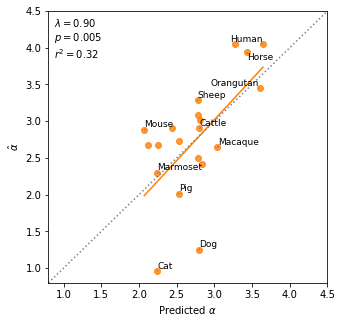

In [8]:
f,ax = plt.subplots(figsize=[5,5])    

# Plot pgls and scatter
group = "Mammals"
stats = plot_pgls(data, group, "predicted_alpha", "pgls_ml", ax, palette[group])
identity_line(ax,color="gray", ls="dotted")

# Species text
selected_species = ["Homo_sapiens","Equus_caballus","Pongo_abelii","Ovis_aries","Canis_lupus_familiaris","Felis_catus","Macaca_mulatta","Mus_musculus","Callithrix_jacchus","Bos_taurus","Sus_scrofa"]
plot_sp_text(data, group, "predicted_alpha", sp2common, selected_species, ax)

# Stats
ax.text(s = r"$\lambda={:.2f}$".format(stats["lambda"]) + "\n" + r"$p={:.3f}$".format(stats["pval"]) + "\n" + r"$r^2={:.2f}$".format(stats["r2"]),
        x=0.02, y=0.98, va="top",ha="left", transform=ax.transAxes)

# X axis
ax.set_xlabel(r"Predicted $\alpha$")

# Y axis
ax.set_ylabel(r"$\hat{\alpha}$")

# Style
range_axes = [0.8,4.5]
ax.set_xlim(range_axes)
ax.set_ylim(range_axes)

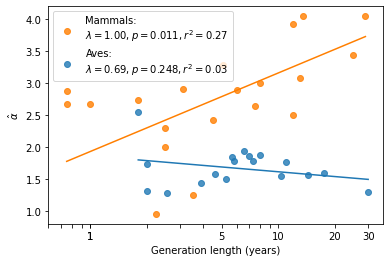

In [9]:
f,ax = plt.subplots()    

# Plot pgls and scatter
for group in ["Mammals", "Aves"]:
    plot_pgls(data, group, "GenerationLength_d", "pgls_ml", ax, palette[group])

# X axis
original_Gs = list(np.linspace(0.6,1,5)) + list(range(1,11)) + [20,30]
xlabels = ["" if g not in [1,5,10,20,30] else g for g in original_Gs]
log10_Gs = np.log10(original_Gs)
ax.set_xticks(log10_Gs)
ax.set_xticklabels(xlabels)
ax.set_xlabel(r"Generation length (years)")

# Y axis
ax.set_ylabel(r"$\hat{\alpha}$")

ax.legend()

In [20]:
yearly_rates = pd.read_csv("../data/subrate_div_data.txt",sep="\t")

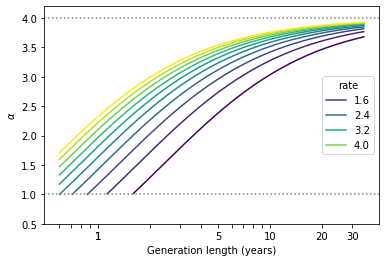

In [55]:
f,ax = plt.subplots()


#l_rate = yearly_rates.MutPerYearUCSC.min()/1e6
l_rate = yearly_rates[yearly_rates.Species=="Homo_sapiens"].MutPerYearUCSC.values[0]/1e6
h_rate = yearly_rates[yearly_rates.Species=="Mus_musculus"].MutPerYearUCSC.values[0]/1e6
n_e = 5/3.1e9
Gs = list(np.linspace(0.6, 1, 1000)) + list(np.linspace(1, 35, 1000))

# Plot alpha vs. time for different rates
rates_alphas = pd.DataFrame()
for rate in np.linspace(l_rate, h_rate, 10):
    alphas = model_alpha_vs_time(rate, n_e, Gs, 4)
    current_df = pd.DataFrame([np.log10(Gs),alphas,[rate]*len(Gs)]).transpose()
    current_df.columns = ["g","alpha","rate"]
    current_df = current_df[current_df.alpha>1]
    rates_alphas = pd.concat([rates_alphas, current_df])
rates_alphas.columns = ["g","alpha","rate"]
sns.lineplot(data=rates_alphas, x="g",y="alpha",hue="rate",palette="viridis")

# Vertial lines
ax.axhline(y=4, linestyle="dotted", color="gray")
ax.axhline(y=1, linestyle="dotted", color="gray")

# Styling
ax.set_ylim([0.5,4.2])
ax.set_xticks(log10_Gs)
ax.set_xticklabels(xlabels)
ax.set_xlabel(r"Generation length (years)")
ax.set_ylabel(r"$\alpha$")

plt.show()

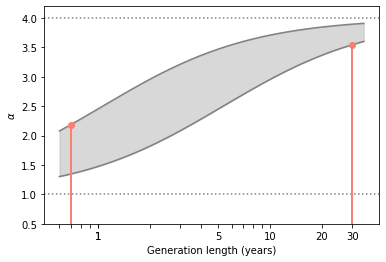

In [11]:
f,ax = plt.subplots()


l_rate = 3
h_rate = 15
n_e = 4
Gs = list(np.linspace(0.6, 1, 1000)) + list(np.linspace(1, 35, 1000))

h_alphas = model_alpha_vs_time(h_rate, n_e, Gs, 4)
l_alphas = model_alpha_vs_time(l_rate, n_e, Gs, 4)

# Plot alpha vs. time for different rates
ax.plot(np.log10(Gs), h_alphas, color="gray")
ax.plot(np.log10(Gs), l_alphas, color="gray")
ax.fill_between(np.log10(Gs), h_alphas, l_alphas, color="gray", alpha=0.3)

# Vertial lines
ax.axhline(y=4, linestyle="dotted", color="gray")
ax.axhline(y=1, linestyle="dotted", color="gray")

# Plot for some exemplary species
h_g = 0.7
l_g = 30
for rate,g in zip([l_rate, h_rate],[l_g, h_g]):
    log_g = np.log10(g)
    spec = model_alpha_vs_time(rate, n_e, [g], 4)[0]
    ax.plot([log_g, log_g], [0, spec], color="salmon", linewidth=2)
    ax.scatter(log_g, spec, color="salmon",zorder=10)

# Styling
ax.set_ylim([0.5,4.2])
ax.set_xticks(log10_Gs)
ax.set_xticklabels(xlabels)
ax.set_xlabel(r"Generation length (years)")
ax.set_ylabel(r"$\alpha$")

plt.show()

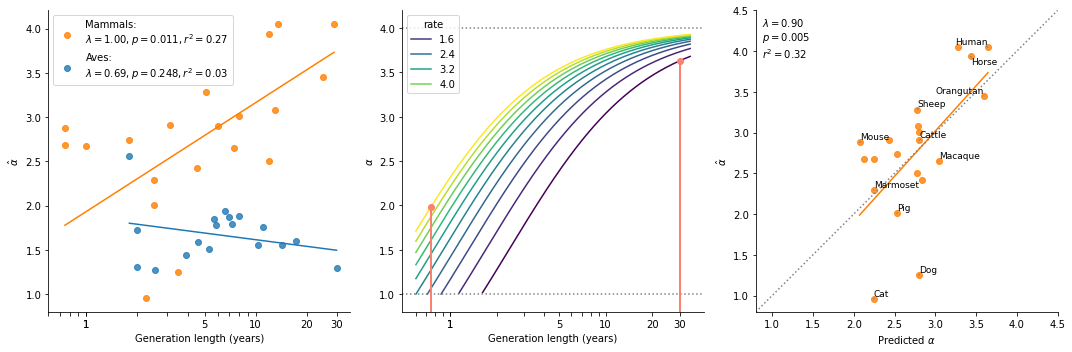

In [61]:
f,axs = plt.subplots(1,3, figsize=[15,15/3])

### G vs. X/A alpha ###

ax = axs[0]
# Plot pgls and scatter
for group in ["Mammals", "Aves"]:
    plot_pgls(data, group, "GenerationLength_d", "pgls_ml", ax, palette[group])
    
# X axis
original_Gs = list(np.linspace(0.6,1,5)) + list(range(1,11)) + [20,30]
xlabels = ["" if g not in [1,5,10,20,30] else g for g in original_Gs]
log10_Gs = np.log10(original_Gs)
ax.set_xticks(log10_Gs)
ax.set_xticklabels(xlabels)
ax.set_xlabel(r"Generation length (years)")

# Y axis
ax.set_ylabel(r"$\hat{\alpha}$")
ax.legend()

### Model ###

ax=axs[1]
l_rate = yearly_rates[yearly_rates.Species=="Homo_sapiens"].MutPerYearUCSC.values[0]/1e6
h_rate = yearly_rates[yearly_rates.Species=="Mus_musculus"].MutPerYearUCSC.values[0]/1e6
n_e = 5/3.1e9
Gs = list(np.linspace(0.6, 1, 1000)) + list(np.linspace(1, 35, 1000))

# Plot alpha vs. time for different rates
rates_alphas = pd.DataFrame()
for rate in np.linspace(l_rate, h_rate, 10):
    alphas = model_alpha_vs_time(rate, n_e, Gs, 4)
    current_df = pd.DataFrame([np.log10(Gs),alphas,[rate]*len(Gs)]).transpose()
    current_df.columns = ["g","alpha","rate"]
    current_df = current_df[current_df.alpha>1]
    rates_alphas = pd.concat([rates_alphas, current_df])
rates_alphas.columns = ["g","alpha","rate"]
sns.lineplot(data=rates_alphas, x="g",y="alpha",hue="rate",palette="viridis",ax=ax)

# Vertial lines
ax.axhline(y=4, linestyle="dotted", color="gray")
ax.axhline(y=1, linestyle="dotted", color="gray")

# Styling
ax.set_ylim([0.5,4.2])
ax.set_xticks(log10_Gs)
ax.set_xticklabels(xlabels)
ax.set_xlabel(r"Generation length (years)")
ax.set_ylabel(r"$\alpha$")

# Plot for some exemplary species
h_g = 0.75
l_g = 30
for rate,g in zip([l_rate, h_rate],[l_g, h_g]):
    log_g = np.log10(g)
    spec = model_alpha_vs_time(rate, n_e, [g], 4)[0]
    ax.plot([log_g, log_g], [0, spec], color="salmon", linewidth=2)
    ax.scatter(log_g, spec, color="salmon",zorder=10)

# Styling
ax.set_ylim([0.8,4.2])
ax.set_xticks(log10_Gs)
ax.set_xticklabels(xlabels)
ax.set_xlabel(r"Generation length (years)")
ax.set_ylabel(r"$\alpha$")

### Predicted alpha vs. X/A alpha ###

ax = axs[2]
# Plot pgls and scatter
group = "Mammals"
stats = plot_pgls(data, group, "predicted_alpha", "pgls_ml", ax, palette[group])
identity_line(ax,color="gray", ls="dotted")

# Species text
selected_species = ["Homo_sapiens","Equus_caballus","Pongo_abelii","Ovis_aries","Canis_lupus_familiaris","Felis_catus","Macaca_mulatta","Mus_musculus","Callithrix_jacchus","Bos_taurus","Sus_scrofa"]
plot_sp_text(data, group, "predicted_alpha", sp2common, selected_species, ax)

# Stats
ax.text(s = r"$\lambda={:.2f}$".format(stats["lambda"]) + "\n" + r"$p={:.3f}$".format(stats["pval"]) + "\n" + r"$r^2={:.2f}$".format(stats["r2"]),
        x=0.02, y=0.98, va="top",ha="left", transform=ax.transAxes)

# X axis
ax.set_xlabel(r"Predicted $\alpha$")

# Y axis
ax.set_ylabel(r"$\hat{\alpha}$")

# Style
range_axes = [0.8,4.5]
ax.set_xlim(range_axes)
ax.set_ylim(range_axes)


sns.despine()
plt.tight_layout()

f.savefig("pdfs/Figure_3.pdf")